## Contaminación del aire por día.

Queremos trabajar sobre estos datos para ver después como afecta la contaminación (si es que afecta) en el uso de las bicicletas. Para esto necesitamos hacer el trabajo previo de lal impieza y transformación de estos datos

Los valores que importan son los siguientes:

The AQI level is based on the level of six atmospheric pollutants, namely sulfur dioxide (SO2), nitrogen dioxide (NO2), suspended particulates smaller than 10 μm in aerodynamic diameter (PM10)suspended particulates smaller than 2.5 μm in aerodynamic diameter (PM2.5)，carbon monoxide (CO), and ozone (O3) measured at the monitoring stations throughout each city

Los codigos del excel de datos son los siguientes:

* 09 -  PM 2.5
* 10 - PM10
* 14 - Ozono O3
* 08 - Dioxido de nitrogeno NO2
* 01 - Dioxido de Azufre SO2
* 06 - Monoxido de carbono CO

**Códigos de estaciones:**

Más céntricas
* Retiro: 49
* Plaza del carmen: 35
* Castellana: 48

En zonas mas alejadas está:
* El pardo: 58
* Casa de campo: 24


**SOLO SON VALIDOS LOS VALORES QUE TIENEN UNA V**

In [77]:
import pandas as pd
from datetime import date, datetime, timedelta
import re
import numpy as np

In [78]:
data2018 = pd.read_excel('../dat/calidadaire2018.xlsx')
data2017 = pd.read_excel('../dat/calidadaire2017.xlsx') 
data2016 = pd.read_excel('../dat/calidadaire2016.xlsx') 

frames = [data2018, data2017, data2016]

data = pd.concat(frames)

Los datos tienen esta pinta. Los días son las columnas pero también están relacionados con otra columna que identifica si es un valor válido o no.

In [79]:
data.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,D02,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,28,79,4,1,28079004_1_38,2018,1,1.0,V,1.0,...,2.0,V,2.0,V,6.0,V,5.0,V,6.0,V
1,28,79,4,1,28079004_1_38,2018,2,5.0,V,3.0,...,3.0,V,2.0,V,0.0,N,0.0,N,0.0,N
2,28,79,4,1,28079004_1_38,2018,3,1.0,V,2.0,...,2.0,V,4.0,V,2.0,V,2.0,V,2.0,V
3,28,79,4,1,28079004_1_38,2018,4,2.0,V,3.0,...,1.0,V,2.0,V,2.0,V,2.0,V,0.0,N
4,28,79,4,1,28079004_1_38,2018,5,2.0,V,2.0,...,2.0,V,2.0,V,3.0,V,2.0,V,2.0,V


Elimino las columns que ya se que no me sirven

In [80]:
del data['PROVINCIA']
del data['MUNICIPIO']
del data['PUNTO_MUESTREO']

## Filtro estaciones y magnitudes de mi intéres

Solo quiero quedarme con una parte de la información. Las magnitudes más importantes y un conjunto de estaciones que representen medidas céntricas de Madrid y de las afueras.

In [81]:
estaciones_utilizar = [24,35,48,49,58]
magnitudes_interes = [1,6,8,9,10,14]
data_copy = data.copy()
data_copy = data_copy[data_copy.ESTACION.isin(estaciones_utilizar)]
data_copy = data_copy[data_copy.MAGNITUD.isin(magnitudes_interes)]

### Convierto datos a formato largo

Asi me quedan los dias y los valores como filas

In [82]:
data_formatted = pd.melt(data_copy, id_vars =['ESTACION', 'MAGNITUD', 'ANO', 'MES'])
data_formatted.head()

,ESTACION,MAGNITUD,ANO,MES,variable,value
0,24,1,2018,1,D01,3
1,24,1,2018,2,D01,5
2,24,1,2018,3,D01,4
3,24,1,2018,4,D01,4
4,24,1,2018,5,D01,3


### Transformación de datos

Necesitaría crearme una columna con la fecha, ya que tengo mes, año y día por separado. Antes necesito limpiar el día ya que tiene una D o una V delante.

Luego voy a separar el dataframe según V o D y voy a cruzarlo por la columna fecha creada.

**Fechas con error**

Las fechas que dan error cuando se quieren castear a tipo datetime (porque no existen. ej: 30/02) las pongo como 1/1/1900 (porque ya se que no existe) para después borrarlas

In [83]:
def get_date_from_columns(row):
    try:
        year = row.ANO
        month = row.MES
        day = int(re.findall('[0-9]+', row.variable)[0])
        return datetime(year, month, day)
    except:
        #DA ERROR EN DIAS QUE NO EXISTEN. Los voy a borrar despues
        return datetime(1900,1,1)

def convert_to_letter(variable):
    return re.findall('[A-Z]+',variable)[0]

data_formatted['date'] = data_formatted.apply(get_date_from_columns, axis=1)
data_formatted['variable'] = data_formatted.variable.apply(convert_to_letter)

#Elimino las fechas que están mal-
data_formatted = data_formatted[data_formatted.date != date(1900,1,1)]

data_formatted.head(1)

C:\Users\Xseed\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.


,ESTACION,MAGNITUD,ANO,MES,variable,value,date
0,24,1,2018,1,D,3,2018-01-01


In [84]:
data_formatted.shape #Confirmo se eliminaron filas

(36898, 7)

### Separo dataframe y lo cruzo por fecha, magnitud y estación

Separo el dataframe según el tipo D o V y lo cruzo para saber que días tienen valores válidos y cuales no. Elimino los que no son válidos. Filtro por aquellos con valor 'V'

In [85]:
data_formatted_D = data_formatted[data_formatted.variable == 'D'].sort_values(['ESTACION','MES', 'MAGNITUD'])
data_formatted_V = data_formatted[data_formatted.variable == 'V'].sort_values(['ESTACION','MES', 'MAGNITUD'])

#Cruzo dataframes que separé
data_formatted = data_formatted_D.merge(data_formatted_V, on=['date','MAGNITUD', 'ESTACION'])

#Filtro por aquellos días que tengan la V y elimino los que tienen la 'N' de no válido
data_formatted = data_formatted[data_formatted.value_y == 'V']

### Transformación de columnas

Elimino columnas que no me sirven y cambio nombres para que sean mas descriptivos

In [86]:
#Borro columnas que no me interesan.
del(data_formatted['variable_y'])
del(data_formatted['value_y'])
del(data_formatted['MES_y'])
del(data_formatted['ANO_y'])
del(data_formatted['variable_x'])

#Cambio nombre de las columnas y converto medicion a numero.
data_formatted.columns = ['estacion', 'magnitud', 'ano', 'mes', 'medicion','fecha']
data_formatted["medicion"] = pd.to_numeric(data_formatted["medicion"])

La tabla resultado se ve a continuación.

In [87]:
data_formatted.head()

,estacion,magnitud,ano,mes,medicion,fecha
0,24,1,2018,1,3.0,2018-01-01
1,24,1,2017,1,3.0,2017-01-01
2,24,1,2016,1,2.0,2016-01-01
4,24,1,2017,1,3.0,2017-01-02
5,24,1,2016,1,2.0,2016-01-02


## Reemplazo magnitudes y estaciones por su nombre

Las magnitudes y las estaciones están identificadas por un número. Para saber a qué corresponden les cambio los números por su valor correspondiente

In [89]:
def get_magnitud_name(value):
    if value == 1:
        return 'Dioxido de Azufre SO2'
    elif value == 6:
        return 'Monoxido de carbono CO'
    elif value == 8:
        return 'Dioxido de nitrogeno NO2'
    elif value == 9:
        return 'PM 2.5'
    elif value == 10:
        return 'PM10'
    elif value == 14:
        return 'Ozono O3'

def get_station_name(value):
    if value == 49:
        return 'Retiro'
    elif value == 35:
        return 'Plaza del carmen'
    elif value == 48:
        return 'Castellana'
    elif value == 58:
        return 'El Pardo'
    elif value == 24:
        return 'Casa de campo'
            
data_formatted['magnitud'] = data_formatted.magnitud.apply(get_magnitud_name)
data_formatted['estacion'] = data_formatted.estacion.apply(get_station_name)

## Visualización de datos

In [53]:
#Valores maximos para cada magnitud en el 2018
valores_max = data2018_formatted.groupby(['magnitud']).medicion.max()

In [90]:
valores_max.to_dict()

,estacion,magnitud,ano,mes,medicion,fecha
0,Casa de campo,Dioxido de Azufre SO2,2018,1,3.0,2018-01-01
1,Casa de campo,Dioxido de Azufre SO2,2017,1,3.0,2017-01-01
2,Casa de campo,Dioxido de Azufre SO2,2016,1,2.0,2016-01-01
4,Casa de campo,Dioxido de Azufre SO2,2017,1,3.0,2017-01-02
5,Casa de campo,Dioxido de Azufre SO2,2016,1,2.0,2016-01-02


In [55]:
media_no2 = data2018_formatted[data2018_formatted.magnitud == 'Dioxido de nitrogeno NO2'].medicion.mean()
media_no2

29.365140650854936

In [26]:
def get_season(row):
    date = row.fecha
    if date >= datetime(date.year, 3, 21) and date <= datetime(date.year, 6, 20):
        return 'Primavera'
    elif date >= datetime(date.year, 6, 21) and date <= datetime(date.year, 9 , 20):
        return 'Verano'
    elif date >= datetime(date.year, 9, 21) and date <= datetime(date.year, 12 , 20):
        return 'Otoño'
    else:
        return 'Invierno'
    
data2018_formatted['estacion_del_año'] = data2018_formatted.apply(get_season, axis = 1)

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 10
sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.despine()
sns.set_style("dark")

#umbral valores permitidos
valores_permitidos = {
    'Dioxido de nitrogeno NO2': 40,
    'PM 10': 40,
    'PM 2.5': 10,
    'Ozono': 120
}

<Figure size 1008x720 with 0 Axes>

C:\Users\Xseed\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


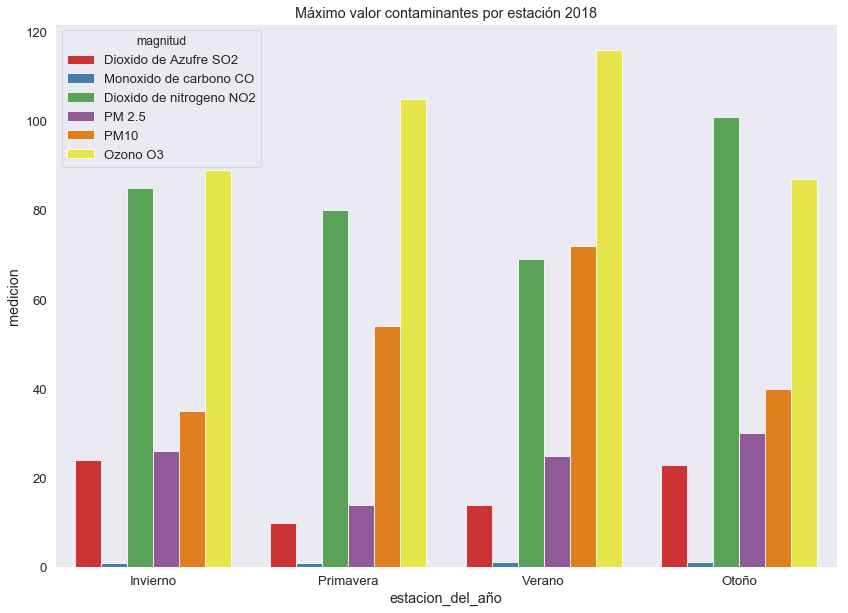

In [28]:
#Máximo valor contaminantes en cada estacion del año

plt.xlabel('Estación')
plt.ylabel('Medición')
plt.title('Máximo valor contaminantes por estación 2018') 
out = sns.barplot(x='estacion_del_año', y ='medicion' , data=data2018_formatted, estimator = np.max, hue='magnitud', palette="Set1", ci=0)

### Activación Protocolos de contaminación 2018.
* NO2 del 23 al 24 de enero
* NO2 del 5 al 7 de diciembre de 2018
* NO2 del 11 al 12 de diciembre de 2018
* NO2 del 25 al 28 de diciembre de 2018

In [261]:
data2018_formatted[(data2018_formatted.magnitud == 'Dioxido de nitrogeno NO2') & 
                   (data2018_formatted.fecha == datetime(2018,12,5))]


,estacion,magnitud,ano,mes,medicion,fecha
1887,Otoño,Dioxido de nitrogeno NO2,2018,12,49.0,2018-12-05
3409,Otoño,Dioxido de nitrogeno NO2,2018,12,71.0,2018-12-05
4473,Otoño,Dioxido de nitrogeno NO2,2018,12,75.0,2018-12-05
5234,Otoño,Dioxido de nitrogeno NO2,2018,12,54.0,2018-12-05
5964,Otoño,Dioxido de nitrogeno NO2,2018,12,30.0,2018-12-05


In [281]:
data2018_formatted.head()

,estacion,magnitud,ano,mes,medicion,fecha,estacion_del_año
0,Casa de campo,Dioxido de Azufre SO2,2018,1,3.0,2018-01-01,Invierno
4,Casa de campo,Dioxido de Azufre SO2,2018,1,3.0,2018-01-05,Invierno
5,Casa de campo,Dioxido de Azufre SO2,2018,1,3.0,2018-01-06,Invierno
6,Casa de campo,Dioxido de Azufre SO2,2018,1,3.0,2018-01-07,Invierno
7,Casa de campo,Dioxido de Azufre SO2,2018,1,4.0,2018-01-08,Invierno
